# NOTE:
# This notebook contains lots and lots of copy paste code used for generating the plots for the paper. It should be run from the top as several variables are overwritten throughout the code.

In [1]:
import sys
import os
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import tifffile as tiff
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image

sys.path.insert(0, '../')
from src.models.params import get_params
from src.utils import extract_collapsed_cls
from src.models.evaluate_model import calculate_evaluation_criteria

Image.MAX_IMAGE_PIXELS = 1000000000   
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'

Set plotting parameters

In [2]:
# Change font size in seaborn and matplotlib
current_palette = sns.color_palette()
sns.set(font_scale=1.5) 
sns.set_style("ticks")
sns.set_palette(current_palette)

matplotlib_font_size = 15

# SPARCS as test dataset

### Plot coverage scatterplot of fmask vs. ground truth

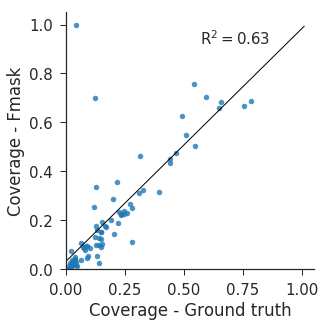

In [3]:
matplotlib.rcParams.update({'font.size': 22})
# Extract data in correct format for plotting
x = pd.read_csv('../reports/Unet/fmask_results_SPARCS.csv')

tp = [col for col in x.columns if 'tp' in col]
tp = x[tp]
tp_np = tp.values

fp = [col for col in x.columns if 'fp' in col]
fp = x[fp]
fp_np = fp.values

fn = [col for col in x.columns if 'fn' in col]
fn = x[fn]
fn_np = fn.values

npix = [col for col in x.columns if 'npix' in col]
npix = x[npix]
npix_np = npix.values

coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth[0,:]
df_temp['Coverage - Predicted'] = coverage_predicted[0,:]

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line
           #palette=sns.color_palette("hls", 8),
           legend=True,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.57, 0.92, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - Fmask')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/SPARCS_GroundTruthVsFmaskPlot.pdf")
plt.show()


### Find the models you want to plot

In [4]:
params = get_params('U-net', 'Landsat8')
df = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_SPARCSTrain_SPARCSEval.csv' )

# Add columns with timestamp and cross-validation fold number
df['timestamp'] = df['modelID'].astype(str).str[0:12]
df['cross-val'] = df['modelID'].astype(str).str[15:]

# Add columns with total tp, fp, fn, and tn
tp_cols = [col for col in df.columns if 'tp' in col]  # Get indices for columns
df['total_tp'] = df[tp_cols].sum(axis=1)  # Row-wise sum of tp columns
fp_cols = [col for col in df.columns if 'fp' in col]  
df['total_fp'] = df[fp_cols].sum(axis=1)
fn_cols = [col for col in df.columns if 'fn' in col]  
df['total_fn'] = df[fn_cols].sum(axis=1)
tn_cols = [col for col in df.columns if 'tn' in col]
df['total_tn'] = df[tn_cols].sum(axis=1)
npix_cols = [col for col in df.columns if 'npix' in col]
df['total_npix'] = df[npix_cols].sum(axis=1)

# Average over all the cross-validation folds
df_summed = df.groupby(['timestamp', 'threshold'], as_index=False)['total_tp', 'total_fp', 'total_fn', 'total_tn', 'total_npix'].sum()

# Only use finished runs (i.e. all pixels evaluated should equal the entire SPARCS dataset)
df_summed = df_summed.loc[df_summed['total_npix'] == 80000000]

# Now calculate the evaluation criteria
df_summed['accuracy'] = (df_summed['total_tp'] + df_summed['total_tn']) / df_summed['total_npix']
df_summed['precision'] = df_summed['total_tp'] / (df_summed['total_tp'] + df_summed['total_fp'])
df_summed['recall'] = df_summed['total_tp'] / (df_summed['total_tp'] + df_summed['total_fn'])
df_summed['f-score'] = 2 / (1/df_summed['recall'] + 1/df_summed['precision'])

# Then create an overview df with only relevant information
df_overview = pd.merge(df[['timestamp', 'bands', 'loss_func']], df_summed, on='timestamp').drop_duplicates().reset_index()

# Investigate results
df_overview.\
loc[df_overview['timestamp'].astype(int) > 180713000000].\
loc[df_overview['loss_func'] == 'binary_crossentropy'].\
loc[df['threshold'] == 0.50].\
sort_values('accuracy', ascending=False).\
drop_duplicates(['timestamp']).\
drop_duplicates(['bands']).\
sort_values('bands', ascending=False).head(5)

,index,timestamp,bands,loss_func,threshold,total_tp,total_fp,total_fn,total_tn,total_npix,accuracy,precision,recall,f-score
3296,312274,180731212622,123456791011,binary_crossentropy,0.5,12965709,1832694,2531762,62669835.0,80000000,0.945444,0.876156,0.836634,0.855939
693,64989,180715224351,12345679,binary_crossentropy,0.5,13572652,1596673,1924819,62905856.0,80000000,0.955981,0.894743,0.875798,0.885169
1092,102894,180717162433,2345,binary_crossentropy,0.5,13001237,1620191,2496234,62882338.0,80000000,0.948545,0.889191,0.838926,0.863328
3258,308664,180731141418,234,binary_crossentropy,0.5,13070303,1684805,2427168,62817724.0,80000000,0.948600,0.885815,0.843383,0.864079
370,34304,180714181646,3,binary_crossentropy,0.5,12925237,1677293,2572234,62825236.0,80000000,0.946881,0.885137,0.834022,0.858820


### All bands plot

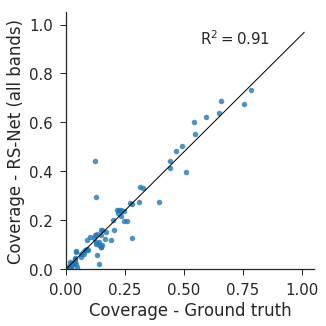

In [5]:
# Get modelID and threshold from the jhj_ArticleTables notebook
modelID = 180731212622  
threshold = 0.50

# Load df
params = get_params('U-net', 'Landsat8')
df_SPARCS = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_SPARCSTrain_SPARCSEval.csv' )

# Add columns with timestamp and cross-validation fold number
df_SPARCS['timestamp'] = df_SPARCS['modelID'].astype(str).str[0:12]
df_SPARCS['cross-val'] = df_SPARCS['modelID'].astype(str).str[15:]

# Find tp, fp, and fn columns
tp_cols = [col for col in df_SPARCS.columns if 'tp' in col]  # Get indices for columns
fp_cols = [col for col in df_SPARCS.columns if 'fp' in col]  
fn_cols = [col for col in df_SPARCS.columns if 'fn' in col]  
npix_cols = [col for col in df_SPARCS.columns if 'npix' in col]  

# Create numpy array with the results from each cross-val fold appended
tp_np = fp_np = fn_np = npix_np = np.array([])
for i in range(1, 6):
    df_temp = df_SPARCS.loc[df_SPARCS['timestamp'] == str(modelID)].\
                        loc[df_SPARCS['threshold'] == threshold].\
                        loc[df_SPARCS['cross-val'] == str(i) + 'of5']        
    tp_np = np.append(tp_np, df_temp[tp_cols].values)
    fp_np = np.append(fp_np, df_temp[fp_cols].values)
    fn_np = np.append(fn_np, df_temp[fn_cols].values)
    npix_np = np.append(npix_np, df_temp[npix_cols].values)
    
# Calculate coverage
coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth
df_temp['Coverage - Predicted'] = coverage_predicted

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line     
           #palette=sns.color_palette("hls", 8),
           legend=True,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.57, 0.92, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - RS-Net (all bands)')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/SPARCS_GroundTruthVsPredictionPlot_AllBands.pdf")
plt.show()

### RGB plot

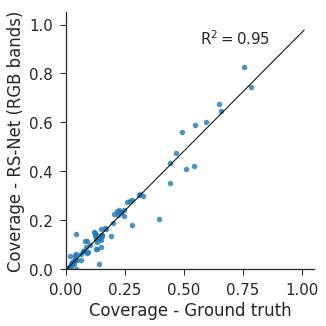

In [6]:
# Get modelID and threshold from the jhj_ArticleTables notebook
modelID = 180731141418  
threshold = 0.50

# Load df
params = get_params('U-net', 'Landsat8')
df_SPARCS = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_SPARCSTrain_SPARCSEval.csv' )

# Add columns with timestamp and cross-validation fold number
df_SPARCS['timestamp'] = df_SPARCS['modelID'].astype(str).str[0:12]
df_SPARCS['cross-val'] = df_SPARCS['modelID'].astype(str).str[15:]

# Find tp, fp, and fn columns
tp_cols = [col for col in df_SPARCS.columns if 'tp' in col]  # Get indices for columns
fp_cols = [col for col in df_SPARCS.columns if 'fp' in col]  
fn_cols = [col for col in df_SPARCS.columns if 'fn' in col]  
npix_cols = [col for col in df_SPARCS.columns if 'npix' in col]  

# Create numpy array with the results from each cross-val fold appended
tp_np = fp_np = fn_np = npix_np = np.array([])
for i in range(1, 6):
    df_temp = df_SPARCS.loc[df_SPARCS['timestamp'] == str(modelID)].\
                        loc[df_SPARCS['threshold'] == threshold].\
                        loc[df_SPARCS['cross-val'] == str(i) + 'of5']        
    tp_np = np.append(tp_np, df_temp[tp_cols].values)
    fp_np = np.append(fp_np, df_temp[fp_cols].values)
    fn_np = np.append(fn_np, df_temp[fn_cols].values)
    npix_np = np.append(npix_np, df_temp[npix_cols].values)
    
# Calculate coverage
coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth
df_temp['Coverage - Predicted'] = coverage_predicted

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line     
           #palette=sns.color_palette("hls", 8),
           legend=True,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.57, 0.92, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - RS-Net (RGB bands)')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/SPARCS_GroundTruthVsPredictionPlot_RGB.pdf")
plt.show()

### Single band plot

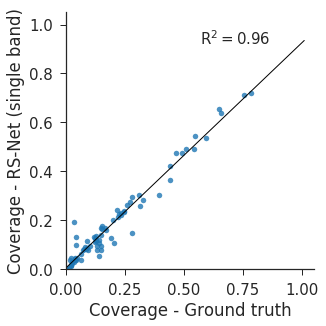

In [7]:
# Get modelID and threshold from the jhj_ArticleTables notebook
modelID = 180714181646  
threshold = 0.50

# Load df
params = get_params('U-net', 'Landsat8')
df_SPARCS = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_SPARCSTrain_SPARCSEval.csv' )

# Add columns with timestamp and cross-validation fold number
df_SPARCS['timestamp'] = df_SPARCS['modelID'].astype(str).str[0:12]
df_SPARCS['cross-val'] = df_SPARCS['modelID'].astype(str).str[15:]

# Find tp, fp, and fn columns
tp_cols = [col for col in df_SPARCS.columns if 'tp' in col]  # Get indices for columns
fp_cols = [col for col in df_SPARCS.columns if 'fp' in col]  
fn_cols = [col for col in df_SPARCS.columns if 'fn' in col]  
npix_cols = [col for col in df_SPARCS.columns if 'npix' in col]  

# Create numpy array with the results from each cross-val fold appended
tp_np = fp_np = fn_np = npix_np = np.array([])
for i in range(1, 6):
    df_temp = df_SPARCS.loc[df_SPARCS['timestamp'] == str(modelID)].\
                        loc[df_SPARCS['threshold'] == threshold].\
                        loc[df_SPARCS['cross-val'] == str(i) + 'of5']        
    tp_np = np.append(tp_np, df_temp[tp_cols].values)
    fp_np = np.append(fp_np, df_temp[fp_cols].values)
    fn_np = np.append(fn_np, df_temp[fn_cols].values)
    npix_np = np.append(npix_np, df_temp[npix_cols].values)
    
# Calculate coverage
coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth
df_temp['Coverage - Predicted'] = coverage_predicted

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line     
           #palette=sns.color_palette("hls", 8),
           legend=True,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.57, 0.92, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - RS-Net (single band)')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/SPARCS_GroundTruthVsPredictionPlot_SingleBand.pdf")
plt.show()

### Plot precision recall curve

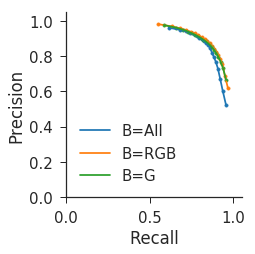

In [8]:
# Choose models
models = [180731212622, 180731141418, 180714181646]  # Must sort for legends to be correct

# Load df
params = get_params('U-net', 'Landsat8')
df_SPARCS = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_SPARCSTrain_SPARCSEval.csv' )

# Sum over the cross validation and calculate evaluation metrics
df_SPARCS['timestamp'] = df_SPARCS['modelID'].astype(str).str[0:12]
df_SPARCS['cross-val'] = df_SPARCS['modelID'].astype(str).str[15:]

# Add columns with total tp, fp, fn, and tn
tp_cols = [col for col in df_SPARCS.columns if 'tp' in col]  # Get indices for columns
df_SPARCS['total_tp'] = df_SPARCS[tp_cols].sum(axis=1)  # Row-wise sum of tp columns
fp_cols = [col for col in df_SPARCS.columns if 'fp' in col]  
df_SPARCS['total_fp'] = df_SPARCS[fp_cols].sum(axis=1)
fn_cols = [col for col in df_SPARCS.columns if 'fn' in col]  
df_SPARCS['total_fn'] = df_SPARCS[fn_cols].sum(axis=1)
tn_cols = [col for col in df_SPARCS.columns if 'tn' in col]
df_SPARCS['total_tn'] = df_SPARCS[tn_cols].sum(axis=1)
npix_cols = [col for col in df_SPARCS.columns if 'npix' in col]
df_SPARCS['total_npix'] = df_SPARCS[npix_cols].sum(axis=1)

# Average over all the cross-validation folds
df_summed = df_SPARCS.groupby(['timestamp', 'threshold'], as_index=False)['total_tp', 'total_fp', 'total_fn', 'total_tn', 'total_npix'].sum()

# Only use finished runs (i.e. all pixels evaluated should equal the entire SPARCS dataset)
df_summed = df_summed.loc[df_summed['total_npix'] == 80000000]

# Now calculate the evaluation criteria
df_summed['accuracy'] = (df_summed['total_tp'] + df_summed['total_tn']) / df_summed['total_npix']
df_summed['precision'] = df_summed['total_tp'] / (df_summed['total_tp'] + df_summed['total_fp'])
df_summed['recall'] = df_summed['total_tp'] / (df_summed['total_tp'] + df_summed['total_fn'])
df_summed['f-score'] = 2 / (1/df_summed['recall'] + 1/df_summed['precision'])

df_prec_rec_curve = pd.DataFrame(columns=['Model', 'Threshold', 'Precision', 'Recall', 'Accuracy', 'F-score'])

for model in models:    
    # Extract model data from df
    x = df_summed.loc[df_summed['timestamp'] == str(model)]
    
    # Create new empty dataframe
    df_temp = pd.DataFrame(columns=['Model', 'Threshold', 'Precision', 'Recall', 'Accuracy', 'F-score'])

    # Add columns
    df_temp['Model'] = x['timestamp']
    df_temp['Threshold'] = x['threshold']
    df_temp['Precision'] = x['precision']
    df_temp['Recall'] = x['recall']
    df_temp['Accuracy'] = x['accuracy']
    df_temp['F-score'] = x['f-score']

    # Manually add extremes
    #df_temp = df_temp.append({'Model': model, 'Threshold': 0, 'Precision': 0, 'Recall': 1}, ignore_index=True)
    #df_temp = df_temp.append({'Model': model, 'Threshold': 1, 'Precision': 1, 'Recall': 0}, ignore_index=True)
    df_prec_rec_curve = df_prec_rec_curve.append(df_temp, ignore_index=True)

# "Hue" in seaborn must be integer
df_prec_rec_curve['Model'] = df_prec_rec_curve['Model'].astype(int)
    
# Plot precision vs recall
g = sns.FacetGrid(df_prec_rec_curve.sort_values('Recall', ascending=True),
                  hue='Model',
                  hue_order=models,
                  size=4)
g.map(plt.scatter, "Recall", "Precision", marker=".")#.add_legend()
g.map(plt.plot, "Recall", "Precision")

legends = ['B=All', 'B=RGB', 'B=G']# models  # Change this if 
plt.legend(legends, loc='best')

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/SPARCS_PrecRecPlot.pdf")
plt.show()

### Plot accuracy vs. threshold

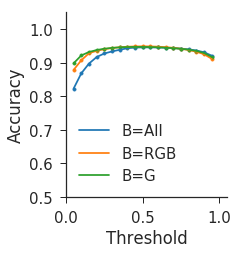

In [9]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_curve.sort_values('Threshold', ascending=True),
                  hue='Model',
                  hue_order=models,
                  size=4)
g.map(plt.scatter, "Threshold", "Accuracy", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "Accuracy")

legends = ['B=All', 'B=RGB', 'B=G']# models  # Change this if 
plt.legend(legends, loc='best')

plt.xlim(0, 1.05)
plt.ylim(0.5, 1.05)

plt.savefig("../reports/figures/dataset_statistics/SPARCS_AccuracyThresholdPlot.pdf")
plt.show()

### Plot F-score vs. threshold

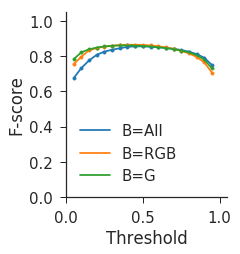

In [10]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_curve.sort_values('Threshold', ascending=True),
                  hue='Model',
                  hue_order=models,
                  size=4)
g.map(plt.scatter, "Threshold", "F-score", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "F-score")

legends = ['B=All', 'B=RGB', 'B=G']# models  # Change this if 
plt.legend(legends, loc='best')

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/SPARCS_FscoreThresholdPlot.pdf")
plt.show()

# Biome as test dataset

### Plot coverage scatterplot of fmask vs. ground truth

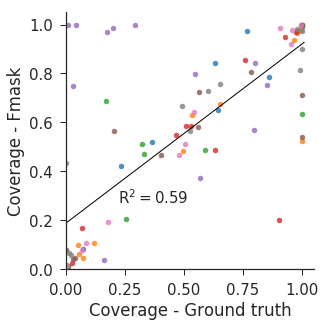

In [25]:
# Extract data in correct format for plotting
x = pd.read_csv('../reports/Unet/fmask_results_Biome.csv')

biomes = ['Barren', 'Forest', 'GrassCrops', 'Shrubland', 'SnowIce', 'Urban', 'Water', 'Wetlands']
biomes_array = np.array([])
for biome in biomes:
    for i in range(12):
        biomes_array = np.append(biomes_array, biome)
 
tp = [col for col in x.columns if 'tp' in col]
tp = x[tp]
tp_np = tp.values

fp = [col for col in x.columns if 'fp' in col]
fp = x[fp]
fp_np = fp.values

fn = [col for col in x.columns if 'fn' in col]
fn = x[fn]
fn_np = fn.values

npix = [col for col in x.columns if 'npix' in col]
npix = x[npix]
npix_np = npix.values

coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth[0,:]
df_temp['Coverage - Predicted'] = coverage_predicted[0,:]
df_temp['Biome'] = biomes_array

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line
           hue="Biome", # Set color,
           #palette=sns.color_palette("hls", 8),
           legend=False,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.22, 0.27, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - Fmask')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/Biome_GroundTruthVsFmaskPlot.pdf")
plt.show()

### Find the models you want to plot

In [12]:
params = get_params('U-net', 'Landsat8')
df = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_BiomeTrain_BiomeEval.csv' )

# Add columns with timestamp and cross-validation fold number
df['timestamp'] = df['modelID'].astype(str).str[0:12]
df['cross-val'] = df['modelID'].astype(str).str[15:]

# Get product names of the categories 
products_clear = []
products_clear = np.append(products_clear, params.test_tiles[0][0::6]) # Every 6th product is clear in train_tiles
products_clear = np.append(products_clear, params.test_tiles[0][1::6])
products_clear = np.append(products_clear, params.test_tiles[1][0::6])
products_clear = np.append(products_clear, params.test_tiles[1][1::6])
products_midcl = []
products_midcl = np.append(products_midcl, params.test_tiles[0][2::6])
products_midcl = np.append(products_midcl, params.test_tiles[0][3::6])
products_midcl = np.append(products_midcl, params.test_tiles[1][2::6])
products_midcl = np.append(products_midcl, params.test_tiles[1][3::6])
products_cloud = []
products_cloud = np.append(products_cloud, params.test_tiles[0][4::6])
products_cloud = np.append(products_cloud, params.test_tiles[0][5::6])
products_cloud = np.append(products_cloud, params.test_tiles[1][4::6])
products_cloud = np.append(products_cloud, params.test_tiles[1][5::6])

products_barren = np.append(params.test_tiles[0][0:6], params.test_tiles[1][0:6])
products_forest = np.append(params.test_tiles[0][6:12], params.test_tiles[1][6:12])
products_grasscrops = np.append(params.test_tiles[0][12:18], params.test_tiles[1][12:18])
products_shrubland = np.append(params.test_tiles[0][18:24], params.test_tiles[1][18:24])
products_snowice = np.append(params.test_tiles[0][24:30], params.test_tiles[1][24:30])
products_urban = np.append(params.test_tiles[0][30:36], params.test_tiles[1][30:36])
products_water = np.append(params.test_tiles[0][36:42], params.test_tiles[1][36:42])
products_wetlands = np.append(params.test_tiles[0][42:48], params.test_tiles[1][42:48])

products_total = np.append(params.test_tiles[0][:], params.test_tiles[1][:])

product_categories = ['Barren', 'Forest', 'GrassCrops', 'Shrubland', 'SnowIce', 'Urban', 'Water', 'Wetlands', 'Clear', 'MidCl', 'Cloud', 'Total']
product_names = [products_barren, 
                 products_forest, 
                 products_grasscrops,
                 products_shrubland,
                 products_snowice,
                 products_urban,
                 products_water,
                 products_wetlands,
                 products_clear, 
                 products_midcl, 
                 products_cloud, 
                 products_total]

# Now loop over categories and cross_val folds and sum evaluation results
cross_vals = 2
df_cv = pd.DataFrame()
for cross_val in range(cross_vals):
    # Extract the results for specific cross_val into new df
    df_temp = df.loc[df['cross-val'] == str(cross_val+1) + 'of' + str(cross_vals)]
    
    # Sum the evaluation criteria for the products in the specific categories
    for i, category in enumerate(product_categories):
        # Get location of products in the respected cross_val fold
        col_location = [df.columns.get_loc(col) for col in df_temp.columns if df_temp[col].iloc[0] in product_names[i]]  # Get indices for columns        
        
        # Use locations to sum up tp, fp, fn, and fp for the respective category and cross_val fold        
        df_temp['total_tp_' + category] = df_temp.iloc[:, np.array(col_location) + 2].sum(axis=1)
        df_temp['total_fp_' + category] = df_temp.iloc[:, np.array(col_location) + 3].sum(axis=1)
        df_temp['total_fn_' + category] = df_temp.iloc[:, np.array(col_location) + 4].sum(axis=1)
        df_temp['total_tn_' + category] = df_temp.iloc[:, np.array(col_location) + 5].sum(axis=1)
        df_temp['total_npix_' + category] = df_temp.iloc[:, np.array(col_location) + 6].sum(axis=1)
                
    # Concatenate the cv df to the final df
    df_cv = df_cv.append(df_temp, ignore_index = True) 
            
# Calculate the final df for the products by grouping the models and thresholds by summing
df_summed = df_cv.groupby(['timestamp', 'threshold'], as_index=False).sum()
        
# Calculate accuracy, precision, recall, and f-score (4 for loops to make it directly usable in the latex code for the table)
for category in product_categories:
    df_summed[category + '_accuracy'] = (df_summed['total_tp_' + category] + df_summed['total_tn_' + category]) / df_summed['total_npix_' + category]

for category in product_categories:
    df_summed[category + '_precision'] = df_summed['total_tp_' + category] / (df_summed['total_tp_' + category] + df_summed['total_fp_' + category])

for category in product_categories:
    df_summed[category + '_recall'] = df_summed['total_tp_' + category] / (df_summed['total_tp_' + category] + df_summed['total_fn_' + category])

for category in product_categories:
    df_summed[category + '_f-score'] = 2 * (df_summed[category + '_precision'] * df_summed[category + '_recall']) / (df_summed[category + '_precision'] + df_summed[category + '_recall'])

# Now merge with original dataframe to avoid using the summed hyperparameters
df_overview = pd.merge(df[['timestamp', 'bands', 'dropout', 'epochs', 'loss_func']], df_summed.iloc[:, pd.np.r_[:2, -48:0]], on='timestamp').drop_duplicates().reset_index()

# Investigate results
df_overview.\
loc[df_overview['timestamp'].astype(int) > 180713000000].\
loc[df['threshold'] == 0.50].\
sort_values('Total_accuracy', ascending=False).\
drop_duplicates(['timestamp']).\
drop_duplicates(['bands']).\
sort_values('bands', ascending=False).head(5)

/home/jhj/anaconda3/envs/CloudDetection/lib/python3.6/site-packages/ipykernel/__main__.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,index,timestamp,bands,dropout,epochs,loss_func,threshold,Barren_accuracy,Forest_accuracy,GrassCrops_accuracy,Shrubland_accuracy,SnowIce_accuracy,Urban_accuracy,Water_accuracy,Wetlands_accuracy,Clear_accuracy,MidCl_accuracy,Cloud_accuracy,Total_accuracy,Barren_precision,Forest_precision,GrassCrops_precision,Shrubland_precision,SnowIce_precision,Urban_precision,Water_precision,Wetlands_precision,Clear_precision,MidCl_precision,Cloud_precision,Total_precision,Barren_recall,Forest_recall,GrassCrops_recall,Shrubland_recall,SnowIce_recall,Urban_recall,Water_recall,Wetlands_recall,Clear_recall,MidCl_recall,Cloud_recall,Total_recall,Barren_f-score,Forest_f-score,GrassCrops_f-score,Shrubland_f-score,SnowIce_f-score,Urban_f-score,Water_f-score,Wetlands_f-score,Clear_f-score,MidCl_f-score,Cloud_f-score,Total_f-score
1491,56325,180802042004,123456791011,0.0,21,binary_crossentropy,0.5,0.951548,0.933623,0.958580,0.937645,0.883925,0.963051,0.957395,0.919419,0.979602,0.913456,0.921574,0.938097,0.953980,0.985774,0.992702,0.962987,0.825219,0.953522,0.955750,0.978072,0.806346,0.944537,0.964559,0.953706,0.941004,0.898308,0.919580,0.907304,0.873430,0.967455,0.954297,0.864568,0.699756,0.873528,0.948249,0.915408,0.947448,0.940011,0.954743,0.934316,0.848640,0.960438,0.955023,0.917824,0.749279,0.907646,0.956334,0.934165
1548,58130,180802211449,12345679,0.0,42,binary_crossentropy,0.5,0.954587,0.937926,0.964613,0.947088,0.843321,0.958608,0.953865,0.891987,0.959138,0.910685,0.924668,0.931419,0.955970,0.964819,0.978004,0.951221,0.793456,0.941799,0.945051,0.960096,0.521415,0.925199,0.979245,0.940661,0.945715,0.926564,0.946811,0.939950,0.783372,0.970702,0.958391,0.826846,0.753300,0.888365,0.936676,0.914760,0.950815,0.945305,0.962155,0.945552,0.788382,0.956032,0.951674,0.888503,0.616266,0.906408,0.957488,0.927529
2042,76902,180806203105,2345,0.0,31,binary_crossentropy,0.5,0.952091,0.939269,0.962391,0.950381,0.708365,0.972965,0.947684,0.935639,0.932364,0.886559,0.944236,0.921008,0.977748,0.961492,0.984596,0.957559,0.597011,0.965928,0.950309,0.938346,0.349785,0.913155,0.976848,0.921546,0.917663,0.932441,0.935475,0.940156,0.668363,0.976115,0.938711,0.937975,0.643621,0.847597,0.961210,0.913090,0.946753,0.946744,0.959407,0.948778,0.630675,0.970995,0.944474,0.938161,0.453246,0.879156,0.968966,0.917298
1966,74014,180806004148,234,0.0,117,binary_crossentropy,0.5,0.931017,0.939709,0.958733,0.925479,0.836349,0.939887,0.959705,0.922142,0.976324,0.876133,0.927802,0.926606,0.897560,0.985105,0.983850,0.966920,0.800476,0.905764,0.952896,0.966931,0.793257,0.870411,0.979965,0.936853,0.961063,0.909611,0.928380,0.877562,0.746911,0.971396,0.962570,0.880529,0.617328,0.875989,0.939491,0.908241,0.928227,0.945854,0.955311,0.920076,0.772766,0.937433,0.957708,0.921709,0.694322,0.873191,0.959301,0.922325
1377,51993,180801080940,3,0.0,52,binary_crossentropy,0.5,0.890270,0.899991,0.954269,0.898830,0.813366,0.958205,0.945723,0.856802,0.974503,0.878122,0.854193,0.902083,0.920558,0.992949,0.985447,0.975660,0.785439,0.959084,0.966871,0.980679,0.793922,0.903841,0.985048,0.951426,0.835705,0.833167,0.917292,0.813309,0.686613,0.950390,0.916907,0.739448,0.559992,0.838906,0.851941,0.838730,0.876082,0.906068,0.950149,0.887117,0.732709,0.954717,0.941226,0.843149,0.656748,0.870164,0.913672,0.891530


### All bands plot

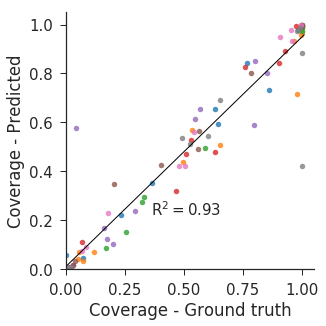

In [21]:
# Get modelID and threshold from the jhj_ArticleTables notebook
modelID = 180802042004  
threshold = 0.50

# Load df
params = get_params('U-net', 'Landsat8')
df_biome = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_BiomeTrain_BiomeEval.csv' )

# Add columns with timestamp and cross-validation fold number
df_biome['timestamp'] = df_biome['modelID'].astype(str).str[0:12]
df_biome['cross-val'] = df_biome['modelID'].astype(str).str[15:]

# Find tp, fp, and fn columns
biome_cols = [col for col in df_biome.columns if 'biome' in col] # Get indices for columns
tp_cols = [col for col in df_biome.columns if 'tp' in col]  
fp_cols = [col for col in df_biome.columns if 'fp' in col]  
fn_cols = [col for col in df_biome.columns if 'fn' in col]  
npix_cols = [col for col in df_biome.columns if 'npix' in col]  

# Create numpy array with the results from each cross-val fold appended
tp_np = fp_np = fn_np = npix_np = biome_np = np.array([])
for i in range(1, 3):
    df_temp = df_biome.loc[df_biome['timestamp'] == str(modelID)].\
                       loc[df_biome['threshold'] == threshold].\
                       loc[df_biome['cross-val'] == str(i) + 'of2']        
    tp_np = np.append(tp_np, df_temp[tp_cols].values)
    fp_np = np.append(fp_np, df_temp[fp_cols].values)
    fn_np = np.append(fn_np, df_temp[fn_cols].values)
    npix_np = np.append(npix_np, df_temp[npix_cols].values)
    biome_np = np.append(biome_np, df_temp[biome_cols].values)
    
# Calculate coverage
coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth
df_temp['Coverage - Predicted'] = coverage_predicted
df_temp['Biome'] = biome_np

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line
           hue="Biome", # Set color           
           #palette=sns.color_palette("hls", 8),
           legend=False,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.36, 0.22, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - Predicted')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/Biome_GroundTruthVsPredictionPlot_AllBands.pdf")
plt.show()

### RGB plot

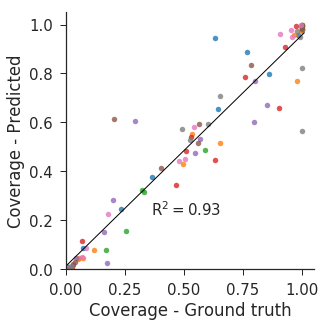

In [22]:
# Get modelID and threshold from the jhj_ArticleTables notebook
modelID = 180806004148  
threshold = 0.50

# Load df
params = get_params('U-net', 'Landsat8')
df_biome = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_BiomeTrain_BiomeEval.csv' )

# Add columns with timestamp and cross-validation fold number
df_biome['timestamp'] = df_biome['modelID'].astype(str).str[0:12]
df_biome['cross-val'] = df_biome['modelID'].astype(str).str[15:]

# Find tp, fp, and fn columns
biome_cols = [col for col in df_biome.columns if 'biome' in col] # Get indices for columns
tp_cols = [col for col in df_biome.columns if 'tp' in col]  
fp_cols = [col for col in df_biome.columns if 'fp' in col]  
fn_cols = [col for col in df_biome.columns if 'fn' in col]  
npix_cols = [col for col in df_biome.columns if 'npix' in col]  

# Create numpy array with the results from each cross-val fold appended
tp_np = fp_np = fn_np = npix_np = biome_np = np.array([])
for i in range(1, 3):
    df_temp = df_biome.loc[df_biome['timestamp'] == str(modelID)].\
                       loc[df_biome['threshold'] == threshold].\
                       loc[df_biome['cross-val'] == str(i) + 'of2']        
    tp_np = np.append(tp_np, df_temp[tp_cols].values)
    fp_np = np.append(fp_np, df_temp[fp_cols].values)
    fn_np = np.append(fn_np, df_temp[fn_cols].values)
    npix_np = np.append(npix_np, df_temp[npix_cols].values)
    biome_np = np.append(biome_np, df_temp[biome_cols].values)
    
# Calculate coverage
coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth
df_temp['Coverage - Predicted'] = coverage_predicted
df_temp['Biome'] = biome_np

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line
           hue="Biome", # Set color           
           #palette=sns.color_palette("hls", 8),
           legend=False,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.36, 0.22, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - Predicted')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/Biome_GroundTruthVsPredictionPlot_RGB.pdf")
plt.show()

### Single band plot

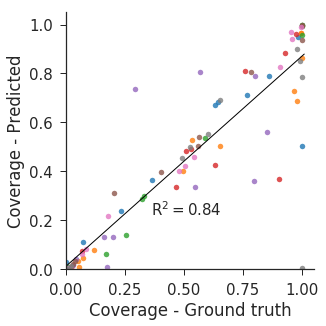

In [23]:
# Get modelID and threshold from the jhj_ArticleTables notebook
modelID = 180801080940  
threshold = 0.50

# Load df
params = get_params('U-net', 'Landsat8')
df_biome = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_BiomeTrain_BiomeEval.csv' )

# Add columns with timestamp and cross-validation fold number
df_biome['timestamp'] = df_biome['modelID'].astype(str).str[0:12]
df_biome['cross-val'] = df_biome['modelID'].astype(str).str[15:]

# Find tp, fp, and fn columns
biome_cols = [col for col in df_biome.columns if 'biome' in col] # Get indices for columns
tp_cols = [col for col in df_biome.columns if 'tp' in col]  
fp_cols = [col for col in df_biome.columns if 'fp' in col]  
fn_cols = [col for col in df_biome.columns if 'fn' in col]  
npix_cols = [col for col in df_biome.columns if 'npix' in col]  

# Create numpy array with the results from each cross-val fold appended
tp_np = fp_np = fn_np = npix_np = biome_np = np.array([])
for i in range(1, 3):
    df_temp = df_biome.loc[df_biome['timestamp'] == str(modelID)].\
                       loc[df_biome['threshold'] == threshold].\
                       loc[df_biome['cross-val'] == str(i) + 'of2']        
    tp_np = np.append(tp_np, df_temp[tp_cols].values)
    fp_np = np.append(fp_np, df_temp[fp_cols].values)
    fn_np = np.append(fn_np, df_temp[fn_cols].values)
    npix_np = np.append(npix_np, df_temp[npix_cols].values)
    biome_np = np.append(biome_np, df_temp[biome_cols].values)
    
# Calculate coverage
coverage_ground_truth  = (tp_np + fn_np) / npix_np
coverage_predicted  = (tp_np + fp_np) / npix_np

# Create empty dataframe
df_temp = pd.DataFrame()

# Add columns
df_temp['Coverage - Ground truth'] = coverage_ground_truth
df_temp['Coverage - Predicted'] = coverage_predicted
df_temp['Biome'] = biome_np

# Create scatterplot of dataframe
sns.lmplot(x='Coverage - Ground truth',
           y='Coverage - Predicted', 
           data=df_temp, # Data source
           size=5, 
           fit_reg=False, # Don't fix a regression line
           hue="Biome", # Set color           
           #palette=sns.color_palette("hls", 8),
           legend=False,
           scatter_kws={"marker": "D", # Set marker style
                        "s": 30}) # S marker size
#plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot x=y line
#plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000), 'k--', linewidth=1)

# Plot regression line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp['Coverage - Ground truth'], df_temp['Coverage - Predicted'])
plt.plot(np.linspace(0,1.01,1000), np.linspace(0,1.01,1000) * slope + intercept, 'k-', linewidth=1)
plt.text(0.36, 0.22, r'$\mathrm{R}^2 = $' + str(np.round(r_value**2, 2)), fontsize=matplotlib_font_size)

# Set x-axis label
plt.xlabel('Coverage - Ground truth')

# Set y-axis label
plt.ylabel('Coverage - Predicted')

# Save figure
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/Biome_GroundTruthVsPredictionPlot_SingleBand.pdf")
plt.show()

### Plot precision recall curve

In [16]:
params = get_params('U-net', 'Landsat8')
df = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_BiomeTrain_BiomeEval.csv' )

# Add columns with timestamp and cross-validation fold number
df['timestamp'] = df['modelID'].astype(str).str[0:12]
df['cross-val'] = df['modelID'].astype(str).str[15:]

# Get product names of the categories 
products_clear = []
products_clear = np.append(products_clear, params.test_tiles[0][0::6]) # Every 6th product is clear in train_tiles
products_clear = np.append(products_clear, params.test_tiles[0][1::6])
products_clear = np.append(products_clear, params.test_tiles[1][0::6])
products_clear = np.append(products_clear, params.test_tiles[1][1::6])
products_midcl = []
products_midcl = np.append(products_midcl, params.test_tiles[0][2::6])
products_midcl = np.append(products_midcl, params.test_tiles[0][3::6])
products_midcl = np.append(products_midcl, params.test_tiles[1][2::6])
products_midcl = np.append(products_midcl, params.test_tiles[1][3::6])
products_cloud = []
products_cloud = np.append(products_cloud, params.test_tiles[0][4::6])
products_cloud = np.append(products_cloud, params.test_tiles[0][5::6])
products_cloud = np.append(products_cloud, params.test_tiles[1][4::6])
products_cloud = np.append(products_cloud, params.test_tiles[1][5::6])

products_barren = np.append(params.test_tiles[0][0:6], params.test_tiles[1][0:6])
products_forest = np.append(params.test_tiles[0][6:12], params.test_tiles[1][6:12])
products_grasscrops = np.append(params.test_tiles[0][12:18], params.test_tiles[1][12:18])
products_shrubland = np.append(params.test_tiles[0][18:24], params.test_tiles[1][18:24])
products_snowice = np.append(params.test_tiles[0][24:30], params.test_tiles[1][24:30])
products_urban = np.append(params.test_tiles[0][30:36], params.test_tiles[1][30:36])
products_water = np.append(params.test_tiles[0][36:42], params.test_tiles[1][36:42])
products_wetlands = np.append(params.test_tiles[0][42:48], params.test_tiles[1][42:48])

products_total = np.append(params.test_tiles[0][:], params.test_tiles[1][:])

product_categories = ['Barren', 'Forest', 'GrassCrops', 'Shrubland', 'SnowIce', 'Urban', 'Water', 'Wetlands', 'Clear', 'MidCl', 'Cloud', 'Total']
product_names = [products_barren, 
                 products_forest, 
                 products_grasscrops,
                 products_shrubland,
                 products_snowice,
                 products_urban,
                 products_water,
                 products_wetlands,
                 products_clear, 
                 products_midcl, 
                 products_cloud, 
                 products_total]

# Now loop over categories and cross_val folds and sum evaluation results
cross_vals = 2
df_cv = pd.DataFrame()
for cross_val in range(cross_vals):
    # Extract the results for specific cross_val into new df
    df_temp = df.loc[df['cross-val'] == str(cross_val+1) + 'of' + str(cross_vals)]
    
    # Sum the evaluation criteria for the products in the specific categories
    for i, category in enumerate(product_categories):
        # Get location of products in the respected cross_val fold
        col_location = [df.columns.get_loc(col) for col in df_temp.columns if df_temp[col].iloc[0] in product_names[i]]  # Get indices for columns        
        
        # Use locations to sum up tp, fp, fn, and fp for the respective category and cross_val fold        
        df_temp['total_tp_' + category] = df_temp.iloc[:, np.array(col_location) + 2].sum(axis=1)
        df_temp['total_fp_' + category] = df_temp.iloc[:, np.array(col_location) + 3].sum(axis=1)
        df_temp['total_fn_' + category] = df_temp.iloc[:, np.array(col_location) + 4].sum(axis=1)
        df_temp['total_tn_' + category] = df_temp.iloc[:, np.array(col_location) + 5].sum(axis=1)
        df_temp['total_npix_' + category] = df_temp.iloc[:, np.array(col_location) + 6].sum(axis=1)
                
    # Concatenate the cv df to the final df
    df_cv = df_cv.append(df_temp, ignore_index = True) 
            
# Calculate the final df for the products by grouping the models and thresholds by summing
df_summed = df_cv.groupby(['timestamp', 'threshold'], as_index=False).sum()
        
# Calculate accuracy, precision, recall, and f-score (4 for loops to make it directly usable in the latex code for the table)
for category in product_categories:
    df_summed[category + '_accuracy'] = (df_summed['total_tp_' + category] + df_summed['total_tn_' + category]) / df_summed['total_npix_' + category]

for category in product_categories:
    df_summed[category + '_precision'] = df_summed['total_tp_' + category] / (df_summed['total_tp_' + category] + df_summed['total_fp_' + category])

for category in product_categories:
    df_summed[category + '_recall'] = df_summed['total_tp_' + category] / (df_summed['total_tp_' + category] + df_summed['total_fn_' + category])

for category in product_categories:
    df_summed[category + '_f-score'] = 2 * (df_summed[category + '_precision'] * df_summed[category + '_recall']) / (df_summed[category + '_precision'] + df_summed[category + '_recall'])

# Now merge with original dataframe to avoid using the summed hyperparameters
df_overview = pd.merge(df[['timestamp', 'bands', 'dropout', 'epochs', 'loss_func']], df_summed.iloc[:, pd.np.r_[:2, -48:0]], on='timestamp').drop_duplicates().reset_index()

# Investigate results
df_overview.\
sort_values('Total_accuracy', ascending=False).\
drop_duplicates(['timestamp']).\
drop_duplicates(['bands']).\
sort_values('bands', ascending=False).head(5)

/home/jhj/anaconda3/envs/CloudDetection/lib/python3.6/site-packages/ipykernel/__main__.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,index,timestamp,bands,dropout,epochs,loss_func,threshold,Barren_accuracy,Forest_accuracy,GrassCrops_accuracy,Shrubland_accuracy,SnowIce_accuracy,Urban_accuracy,Water_accuracy,Wetlands_accuracy,Clear_accuracy,MidCl_accuracy,Cloud_accuracy,Total_accuracy,Barren_precision,Forest_precision,GrassCrops_precision,Shrubland_precision,SnowIce_precision,Urban_precision,Water_precision,Wetlands_precision,Clear_precision,MidCl_precision,Cloud_precision,Total_precision,Barren_recall,Forest_recall,GrassCrops_recall,Shrubland_recall,SnowIce_recall,Urban_recall,Water_recall,Wetlands_recall,Clear_recall,MidCl_recall,Cloud_recall,Total_recall,Barren_f-score,Forest_f-score,GrassCrops_f-score,Shrubland_f-score,SnowIce_f-score,Urban_f-score,Water_f-score,Wetlands_f-score,Clear_f-score,MidCl_f-score,Cloud_f-score,Total_f-score
1488,56322,180802042004,123456791011,0.0,21,binary_crossentropy,0.35,0.950245,0.938925,0.963513,0.944000,0.875849,0.957209,0.955946,0.933482,0.977436,0.915372,0.927091,0.939862,0.938686,0.975971,0.986723,0.953777,0.795265,0.935901,0.943533,0.971998,0.741700,0.923731,0.958308,0.940247,0.955195,0.917082,0.935793,0.930527,0.897925,0.974434,0.964798,0.898075,0.739498,0.900523,0.961321,0.934009,0.946868,0.945611,0.960583,0.942009,0.843483,0.954779,0.954047,0.933575,0.740598,0.911979,0.959812,0.937118
1549,58131,180802211449,12345679,0.0,42,binary_crossentropy,0.55,0.953135,0.937706,0.963414,0.944463,0.854254,0.959914,0.953519,0.889435,0.965055,0.908653,0.922268,0.931899,0.963793,0.972271,0.982183,0.955299,0.825496,0.948028,0.949889,0.963843,0.577959,0.932673,0.981820,0.949278,0.934122,0.918596,0.940045,0.929891,0.771990,0.966517,0.952167,0.818272,0.732933,0.875575,0.931421,0.906492,0.948725,0.944672,0.960652,0.942424,0.797847,0.957183,0.951027,0.885112,0.646286,0.903222,0.955956,0.927392
2043,76903,180806203105,2345,0.0,31,binary_crossentropy,0.55,0.949363,0.938789,0.961110,0.948623,0.728891,0.973768,0.945781,0.934282,0.944565,0.884085,0.939038,0.922490,0.981669,0.965912,0.986779,0.959977,0.643056,0.970124,0.954085,0.942448,0.409142,0.920342,0.980088,0.934330,0.907855,0.926981,0.930613,0.933822,0.612028,0.973392,0.930387,0.930565,0.613980,0.834099,0.952032,0.901829,0.943320,0.946046,0.957873,0.946719,0.627158,0.971756,0.942087,0.936469,0.491056,0.875100,0.965856,0.917792
1961,74009,180806004148,234,0.0,117,binary_crossentropy,0.25,0.923378,0.952772,0.962383,0.947738,0.850923,0.929706,0.956904,0.934487,0.974255,0.876161,0.946824,0.932283,0.871780,0.974330,0.967912,0.942227,0.773310,0.878683,0.933308,0.951377,0.707822,0.835603,0.972374,0.914971,0.978891,0.943274,0.952396,0.951416,0.848625,0.984266,0.979040,0.921215,0.696395,0.928254,0.968811,0.946846,0.922236,0.958550,0.960091,0.946799,0.809219,0.928482,0.955627,0.936053,0.702062,0.879495,0.970589,0.930636
1370,51986,180801080940,3,0.0,52,binary_crossentropy,0.15,0.890452,0.944352,0.959260,0.940578,0.827094,0.943339,0.956709,0.873201,0.970943,0.877769,0.902142,0.916799,0.857537,0.981611,0.953559,0.948654,0.748754,0.904984,0.941842,0.951148,0.663830,0.841202,0.974090,0.914875,0.916182,0.921133,0.961056,0.928696,0.806530,0.980748,0.968469,0.797341,0.674475,0.923210,0.916325,0.911382,0.885890,0.950411,0.957292,0.938569,0.776569,0.941344,0.954970,0.867480,0.669110,0.880300,0.944325,0.913125


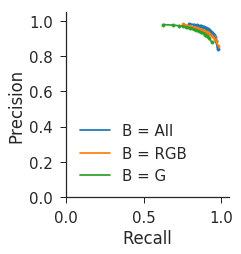

In [17]:
models = [180802042004, 180806004148, 180801080940]  # Must sort for legends to be correct

df_prec_rec_curve = pd.DataFrame(columns=['Model', 'Threshold', 'Precision', 'Recall', 'Accuracy', 'F-score'])

for model in models:
    # Extract model data from df
    x = df_overview.loc[df_overview['timestamp'] == str(model)]

    # Create new empty dataframe
    df_temp = pd.DataFrame(columns=['Model', 'Threshold', 'Precision', 'Recall', 'Accuracy', 'F-score'])

    # Add columns
    df_temp['Model'] = x['timestamp']
    df_temp['Threshold'] = x['threshold']
    df_temp['Precision'] = x['Total_precision']
    df_temp['Recall'] = x['Total_recall']
    df_temp['Accuracy'] = x['Total_accuracy']
    df_temp['F-score'] = x['Total_f-score']

    # Manually add extremes
    #df_temp = df_temp.append({'Model': model, 'Threshold': 0, 'Precision': 0, 'Recall': 1}, ignore_index=True)
    #df_temp = df_temp.append({'Model': model, 'Threshold': 1, 'Precision': 1, 'Recall': 0}, ignore_index=True)
    df_prec_rec_curve = df_prec_rec_curve.append(df_temp, ignore_index=True)

# "Hue" in seaborn must be integer
df_prec_rec_curve['Model'] = df_prec_rec_curve['Model'].astype(int)
    
# Plot precision vs recall
g = sns.FacetGrid(df_prec_rec_curve.sort_values('Recall', ascending=True),
                  hue='Model',
                  hue_order=models,
                  size=4)
g.map(plt.scatter, "Recall", "Precision", marker=".")#.add_legend()
g.map(plt.plot, "Recall", "Precision")

legends = ['B = All', 'B = RGB', 'B = G']  # Change this if 
plt.legend(legends, loc='lower left')

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/Biome_PrecRecPlot.pdf")
plt.show()

### Plot accuracy vs. threshold

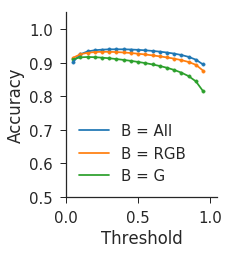

In [18]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_curve.sort_values('Threshold', ascending=True),
                  hue='Model',
                  hue_order=models,
                  size=4)
g.map(plt.scatter, "Threshold", "Accuracy", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "Accuracy")

legends = ['B = All', 'B = RGB', 'B = G']  # Change this if 
plt.legend(legends, loc='best')

plt.xlim(0, 1.05)
plt.ylim(0.5, 1.05)

plt.savefig("../reports/figures/dataset_statistics/Biome_AccuracyThresholdPlot.pdf")
plt.show()

### Plot F-score vs. accuracy

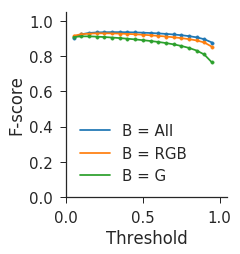

In [19]:
# Plot threshold vs F-score
g = sns.FacetGrid(df_prec_rec_curve.sort_values('Threshold', ascending=True),
                  hue='Model',
                  hue_order=models,
                  size=4)
g.map(plt.scatter, "Threshold", "F-score", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "F-score")

legends = ['B = All', 'B = RGB', 'B = G']  # Change this if 
plt.legend(legends, loc='best')

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/Biome_FscoreThresholdPlot.pdf")
plt.show()

## Do plots for individual biomes (NOT IMPLEMENTED FOR NOW!)

### All bands:

In [20]:
model = 180717051450

df_prec_rec_biome_curve = pd.DataFrame(columns=['Model', 'Threshold', 'Biome', 'Precision', 'Recall', 'Accuracy', 'F-score'])
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
              0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    # Extract data in correct format for plotting
    x = df_overview.loc[df['modelID'] == str(model)].loc[df['threshold'] == threshold]

    biome = [col for col in x.columns if 'biome' in col]
    biome = x[biome]
    biome_np = biome.values

    precision = [col for col in x.columns if 'precision' in col]
    precision = x[precision[:-1]]  # Discard last element - it is the mean value
    precision_np = precision.values
    
    recall = [col for col in x.columns if 'recall' in col]
    recall = x[recall[:-1]]  # Discard last element - it is the mean value
    recall_np = recall.values
    
    accuracy = [col for col in x.columns if 'accuracy' in col]
    accuracy = x[accuracy[:-1]]  # Discard last element - it is the mean value
    accuracy_np = accuracy.values
    
    fscore = [col for col in x.columns if 'f_one_score' in col]
    fscore = x[fscore[:-1]]  # Discard last element - it is the mean value
    fscore_np = fscore.values
    
    products_per_biome = 12
    for i, biome in enumerate(biomes, start=1):
        #print(accuracy_np[0, products_per_biome*(i-1):products_per_biome*i])
        precision_avg = np.average(precision_np[0, products_per_biome*(i-1):products_per_biome*i])
        recall_avg = np.average(recall_np[0, products_per_biome*(i-1):products_per_biome*i])
        accuracy_avg = np.average(accuracy_np[0, products_per_biome*(i-1):products_per_biome*i])
        fscore_avg = np.average(fscore_np[0, products_per_biome*(i-1):products_per_biome*i])
        
        df_prec_rec_biome_curve = df_prec_rec_biome_curve.append({'Model': model,
                                                                  'Threshold': threshold,
                                                                  'Biome': biome,
                                                                  'Precision': precision_avg,
                                                                  'Recall': recall_avg,
                                                                  'Accuracy': accuracy_avg,
                                                                  'F-score': fscore_avg}, ignore_index=True)
        
df_prec_rec_biome_curve.sort_values('Recall', ascending=True).head(5)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# Plot precision vs recall
ax = sns.FacetGrid(df_prec_rec_biome_curve.sort_values(['Biome', 'Recall'], ascending=True),
                  hue='Biome',
                  legend_out=False,
                  size=4)
ax = ax.map(plt.plot, "Recall", "Precision")
ax = ax.map(plt.scatter, "Recall", "Precision", marker=".")

legends = df_prec_rec_biome_curve.sort_values(['Biome', 'Recall'], ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot the legend
plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_PrecRecPlot_AllBands.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_biome_curve.sort_values('Threshold', ascending=True),
                  hue='Biome',
                  size=4)
g.map(plt.scatter, "Threshold", "Accuracy", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "Accuracy")

legends = df_prec_rec_biome_curve.sort_values('Threshold', ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0.5, 1.05)

plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_AccuracyThresholdPlot_AllBands.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_biome_curve.sort_values('Threshold', ascending=True),
                  hue='Biome',
                  size=4)
g.map(plt.scatter, "Threshold", "F-score", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "F-score")

legends = df_prec_rec_biome_curve.sort_values('Threshold', ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_FscoreThresholdPlot_AllBands.pdf")
plt.show()

### RGB

In [ ]:
model = 180612044058

df_prec_rec_biome_curve = pd.DataFrame(columns=['Model', 'Threshold', 'Biome', 'Precision', 'Recall', 'Accuracy', 'F-score'])
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
              0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


for threshold in thresholds:
    # Extract data in correct format for plotting
    x = df.loc[df['modelID'] == model].loc[df['threshold'] == threshold]

    biome = [col for col in x.columns if 'biome' in col]
    biome = x[biome]
    biome_np = biome.values

    precision = [col for col in x.columns if 'precision' in col]
    precision = x[precision[:-1]]  # Discard last element - it is the mean value
    precision_np = precision.values
    
    recall = [col for col in x.columns if 'recall' in col]
    recall = x[recall[:-1]]  # Discard last element - it is the mean value
    recall_np = recall.values
    
    accuracy = [col for col in x.columns if 'accuracy' in col]
    accuracy = x[accuracy[:-1]]  # Discard last element - it is the mean value
    accuracy_np = accuracy.values
    
    fscore = [col for col in x.columns if 'f_one_score' in col]
    fscore = x[fscore[:-1]]  # Discard last element - it is the mean value
    fscore_np = fscore.values
    
    products_per_biome = 12
    for i, biome in enumerate(biomes, start=1):
        #print(accuracy_np[0, products_per_biome*(i-1):products_per_biome*i])
        precision_avg = np.average(precision_np[0, products_per_biome*(i-1):products_per_biome*i])
        recall_avg = np.average(recall_np[0, products_per_biome*(i-1):products_per_biome*i])
        accuracy_avg = np.average(accuracy_np[0, products_per_biome*(i-1):products_per_biome*i])
        fscore_avg = np.average(fscore_np[0, products_per_biome*(i-1):products_per_biome*i])
        
        df_prec_rec_biome_curve = df_prec_rec_biome_curve.append({'Model': model,
                                                                  'Threshold': threshold,
                                                                  'Biome': biome,
                                                                  'Precision': precision_avg,
                                                                  'Recall': recall_avg,
                                                                  'Accuracy': accuracy_avg,
                                                                  'F-score': fscore_avg}, ignore_index=True)
        
df_prec_rec_biome_curve.sort_values('Recall', ascending=True).head(5)

In [ ]:
# Plot precision vs recall
ax = sns.FacetGrid(df_prec_rec_biome_curve.sort_values(['Biome', 'Recall'], ascending=True),
                  hue='Biome',
                  legend_out=False,
                  size=4)
ax = ax.map(plt.plot, "Recall", "Precision")
ax = ax.map(plt.scatter, "Recall", "Precision", marker=".")

legends = df_prec_rec_biome_curve.sort_values(['Biome', 'Recall'], ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot the legend
plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_PrecRecPlot_RGB.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_biome_curve.sort_values('Threshold', ascending=True),
                  hue='Biome',
                  size=4)
g.map(plt.scatter, "Threshold", "Accuracy", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "Accuracy")

legends = df_prec_rec_biome_curve.sort_values('Threshold', ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0.5, 1.05)

plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_AccuracyThresholdPlot_RGB.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_biome_curve.sort_values('Threshold', ascending=True),
                  hue='Biome',
                  size=4)
g.map(plt.scatter, "Threshold", "F-score", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "F-score")

legends = df_prec_rec_biome_curve.sort_values('Threshold', ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_FscoreThresholdPlot_RGB.pdf")
plt.show()

### Single band

In [ ]:
model = 180609181319

df_prec_rec_biome_curve = pd.DataFrame(columns=['Model', 'Threshold', 'Biome', 'Precision', 'Recall', 'Accuracy', 'F-score'])
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
              0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


for threshold in thresholds:
    # Extract data in correct format for plotting
    x = df.loc[df['modelID'] == model].loc[df['threshold'] == threshold]

    biome = [col for col in x.columns if 'biome' in col]
    biome = x[biome]
    biome_np = biome.values

    precision = [col for col in x.columns if 'precision' in col]
    precision = x[precision[:-1]]  # Discard last element - it is the mean value
    precision_np = precision.values
    
    recall = [col for col in x.columns if 'recall' in col]
    recall = x[recall[:-1]]  # Discard last element - it is the mean value
    recall_np = recall.values
    
    accuracy = [col for col in x.columns if 'accuracy' in col]
    accuracy = x[accuracy[:-1]]  # Discard last element - it is the mean value
    accuracy_np = accuracy.values
    
    fscore = [col for col in x.columns if 'f_one_score' in col]
    fscore = x[fscore[:-1]]  # Discard last element - it is the mean value
    fscore_np = fscore.values
    
    products_per_biome = 12
    for i, biome in enumerate(biomes, start=1):
        #print(accuracy_np[0, products_per_biome*(i-1):products_per_biome*i])
        precision_avg = np.average(precision_np[0, products_per_biome*(i-1):products_per_biome*i])
        recall_avg = np.average(recall_np[0, products_per_biome*(i-1):products_per_biome*i])
        accuracy_avg = np.average(accuracy_np[0, products_per_biome*(i-1):products_per_biome*i])
        fscore_avg = np.average(fscore_np[0, products_per_biome*(i-1):products_per_biome*i])
        
        df_prec_rec_biome_curve = df_prec_rec_biome_curve.append({'Model': model,
                                                                  'Threshold': threshold,
                                                                  'Biome': biome,
                                                                  'Precision': precision_avg,
                                                                  'Recall': recall_avg,
                                                                  'Accuracy': accuracy_avg,
                                                                  'F-score': fscore_avg}, ignore_index=True)
        
df_prec_rec_biome_curve.sort_values('Recall', ascending=True).head(5)

In [ ]:
# Plot precision vs recall
ax = sns.FacetGrid(df_prec_rec_biome_curve.sort_values(['Biome', 'Recall'], ascending=True),
                  hue='Biome',
                  legend_out=False,
                  size=4)
ax = ax.map(plt.plot, "Recall", "Precision")
ax = ax.map(plt.scatter, "Recall", "Precision", marker=".")

legends = df_prec_rec_biome_curve.sort_values(['Biome', 'Recall'], ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot the legend
plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_PrecRecPlot_SingleBand.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_biome_curve.sort_values('Threshold', ascending=True),
                  hue='Biome',
                  size=4)
g.map(plt.scatter, "Threshold", "Accuracy", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "Accuracy")

legends = df_prec_rec_biome_curve.sort_values('Threshold', ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0.5, 1.05)

plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_AccuracyThresholdPlot_SingleBand.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_biome_curve.sort_values('Threshold', ascending=True),
                  hue='Biome',
                  size=4)
g.map(plt.scatter, "Threshold", "F-score", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "F-score")

legends = df_prec_rec_biome_curve.sort_values('Threshold', ascending=True).Biome.unique()  # Change this if 
#plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/IndividualBiome_FscoreThresholdPlot_SingleBand.pdf")
plt.show()

## Do plots for clear/midcloudy/cloudy

In [ ]:
model = 180609181319

df_prec_rec_status_curve = pd.DataFrame(columns=['Model', 'Threshold', 'Status', 'Precision', 'Recall', 'Accuracy', 'F-score'])
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
              0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Extract tile names for clear/midcloudy/cloudy tiles
clear = []
midcloudy = []
cloudy = []

train_tiles = params.test_tiles[0]
test_tiles = params.test_tiles[1]

for i in range(48):  # They are ordered already - see it in src/models/params.py
    if i%6 == 0:
        clear.append(train_tiles[i])
        clear.append(train_tiles[i+1])
        clear.append(test_tiles[i])
        clear.append(test_tiles[i+1])
        midcloudy.append(train_tiles[i+2])
        midcloudy.append(train_tiles[i+3])
        midcloudy.append(test_tiles[i+2])
        midcloudy.append(test_tiles[i+3])
        cloudy.append(train_tiles[i+4])
        cloudy.append(train_tiles[i+5])
        cloudy.append(test_tiles[i+4])
        cloudy.append(test_tiles[i+5])
    
# Loop over the thresholds and get the data
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
              0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    # Find the indices of the tiles with the different statuses        
    x = df.loc[df['modelID'] == model].loc[df['threshold'] == threshold]

    clear_indices = []
    midcloudy_indices = []
    cloudy_indices = []

    for i, col in enumerate(x.columns):
        #print(x[col].values)
        if x[col].values in clear:
            clear_indices.append(i)
        if x[col].values in midcloudy:
            midcloudy_indices.append(i)
        if x[col].values in cloudy:
            cloudy_indices.append(i)

    precision = x.iloc[:,[i+8 for i in clear_indices]].values[0]
    recall = x.iloc[:,[i+9 for i in clear_indices]].values[0]
    accuracy = x.iloc[:,[i+7 for i in clear_indices]].values[0]
    fscore = x.iloc[:,[i+10 for i in clear_indices]].values[0]

    df_prec_rec_status_curve = df_prec_rec_status_curve.append({'Model': model,
                                                                'Threshold': threshold,
                                                                'Status': 'Clear',
                                                                'Precision': np.average(precision),
                                                                'Recall': np.average(recall),
                                                                'Accuracy': np.average(accuracy),
                                                                'F-score': np.average(fscore)}, ignore_index=True)
    
    precision = x.iloc[:,[i+8 for i in midcloudy_indices]].values[0]
    recall = x.iloc[:,[i+9 for i in midcloudy_indices]].values[0]
    accuracy = x.iloc[:,[i+7 for i in midcloudy_indices]].values[0]
    fscore = x.iloc[:,[i+10 for i in midcloudy_indices]].values[0]

    df_prec_rec_status_curve = df_prec_rec_status_curve.append({'Model': model,
                                                                'Threshold': threshold,
                                                                'Status': 'Mid-cloudy',
                                                                'Precision': np.average(precision),
                                                                'Recall': np.average(recall),
                                                                'Accuracy': np.average(accuracy),
                                                                'F-score': np.average(fscore)}, ignore_index=True)
    
    precision = x.iloc[:,[i+8 for i in cloudy_indices]].values[0]
    recall = x.iloc[:,[i+9 for i in cloudy_indices]].values[0]
    accuracy = x.iloc[:,[i+7 for i in cloudy_indices]].values[0]
    fscore = x.iloc[:,[i+10 for i in cloudy_indices]].values[0]

    df_prec_rec_status_curve = df_prec_rec_status_curve.append({'Model': model,
                                                                'Threshold': threshold,
                                                                'Status': 'Cloudy',
                                                                'Precision': np.average(precision),
                                                                'Recall': np.average(recall),
                                                                'Accuracy': np.average(accuracy),
                                                                'F-score': np.average(fscore)}, ignore_index=True)
    
df_prec_rec_status_curve.head(5)

In [ ]:
# Plot precision vs recall
ax = sns.FacetGrid(df_prec_rec_status_curve.sort_values(['Status', 'Recall'], ascending=True),
                  hue='Status',
                  legend_out=False,
                  size=4)
ax = ax.map(plt.plot, "Recall", "Precision")
ax = ax.map(plt.scatter, "Recall", "Precision", marker=".")

legends = df_prec_rec_status_curve.sort_values(['Status', 'Recall'], ascending=True).Status.unique()  # Change this if 
plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot the legend
plt.savefig("../reports/figures/dataset_statistics/CloudStatus_PrecRecPlot_SingleBand.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_status_curve.sort_values('Threshold', ascending=True),
                  hue='Status',
                  legend_out=False,
                  size=4)
g.map(plt.scatter, "Threshold", "Accuracy", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "Accuracy")

legends = df_prec_rec_status_curve.sort_values('Threshold', ascending=True).Status.unique()  # Change this if 
plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

# Plot the legend
plt.savefig("../reports/figures/dataset_statistics/CloudStatus_AccuracyThresholdPlot_SingleBand.pdf")
plt.show()

In [ ]:
# Plot threshold vs accuracy
g = sns.FacetGrid(df_prec_rec_status_curve.sort_values('Threshold', ascending=True),
                  hue='Status',
                  size=4)
g.map(plt.scatter, "Threshold", "F-score", marker=".")#.add_legend()
g.map(plt.plot, "Threshold", "F-score")

legends = df_prec_rec_status_curve.sort_values('Threshold', ascending=True).Status.unique()  # Change this if 
plt.legend(legends, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.savefig("../reports/figures/dataset_statistics/CloudStatus_FscoreThresholdPlot_SingleBand.pdf")
plt.show()